In [3]:
import pandas as pd
data=pd.read_csv("train.csv")
tdata=pd.read_csv("test.csv")

In [2]:
def strip_cabin(string):
    if string:
        return 1
    else:
        return 0

def find_women_and_children(string):
    substrings=["Miss", "Master"]
    for s in substrings:
        if s in string:
            return 1
        else:
            return 0

In [1]:
import sklearn.preprocessing as skp
def prep(df):
    features=["Name","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Cabin"] #,"Cabin"
    tmp=df[features]
    tmp["Cabin"].fillna(0,inplace=True)
    tmp["Cabin"]=tmp["Cabin"].apply(strip_cabin)
    tmp["Name"] = tmp["Name"].apply(find_women_and_children)
    tmp=pd.get_dummies(tmp)
    tmp["Age"].fillna(tmp["Age"].mean(), inplace=True)
    return tmp

In [165]:
import torch
def prep(df):
    tmp=pd.DataFrame()
    tmp["Cabin"]=data["Cabin"].fillna(0).apply(strip_cabin)
    tmp["Name"]=data["Name"].apply(find_women_and_children)
    enc=skp.OneHotEncoder()
    label_encoder = skp.LabelEncoder()
    tmp["Gender"]=label_encoder.fit_transform(data["Sex"])
    tmp["Age"]=skp.scale(data["Age"].fillna(data["Age"].mean()))
    tmp["Fare"]=skp.scale(data["Fare"].fillna(data["Fare"].mean()))
    tmp=pd.concat([pd.get_dummies(data["Embarked"].fillna(0)),tmp],axis=1)
    tmp=pd.concat([tmp,data[["SibSp","Parch","Pclass"]]],axis=1)
    return torch.tensor(tmp.values)
# label_encoder = skp.LabelEncoder()
# label_encoder.fit_transform(data["Embarked"].fillna(0))
#label_encoder.fit_transform(data["Sex"])


In [166]:
X=prep(data)
X_t=prep(tdata)
y=torch.tensor(data["Survived"].values)
X

tensor([[0., 0., 0.,  ..., 1., 0., 3.],
        [0., 1., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 3.],
        ...,
        [0., 0., 0.,  ..., 1., 2., 3.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 3.]], dtype=torch.float64)

In [167]:
X.shape,X_t.shape,y.shape

(torch.Size([891, 12]), torch.Size([891, 12]), torch.Size([891]))

In [170]:
D_in=X.shape[1]
H=6
D_out=1
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

In [172]:
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [176]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

traindata = MyDataset(X_t, y)

In [200]:
trainloader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)

In [201]:
epochs=5
for e in range(epochs):
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'mat1' in call to _th_addmm

In [196]:
for i, data in enumerate(trainloader, 0):
    i

In [153]:
from keras.models import Sequential
from keras.layers import Dense,Dropout

ModuleNotFoundError: No module named 'keras'

In [197]:
Model=Sequential()
Model.add(Dense(8,input_dim=12,activation="relu"))
#Model.add(Dropout(0.5))
#Model.add(Dense(4, activation='relu'))
#Model.add(Dropout(0.5))
Model.add(Dense(1, activation='sigmoid'))
Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#validation training
#hist=Model.fit(X, y,validation_split=0.33, epochs=50, batch_size=20)
hist=Model.fit(X, y, epochs=100, batch_size=20)

NameError: name 'Sequential' is not defined

In [122]:
_,eff=Model.evaluate(X, y)
print("Efficiency: %s" % eff)

891/891 [==============================] - 0s 74us/step
Efficiency: 0.8092031478881836


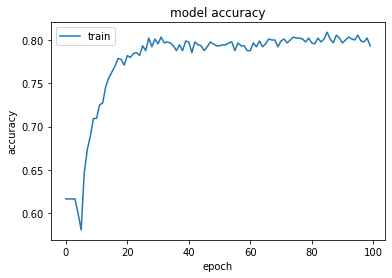

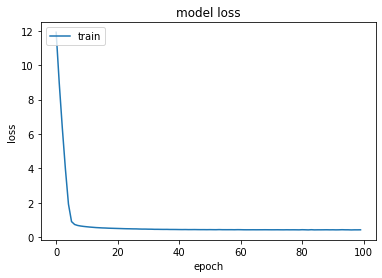

In [123]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
#plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

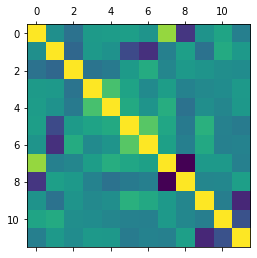

In [124]:
plt.matshow(X.corr())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 9         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
None


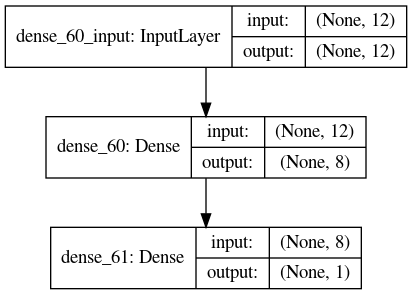

In [125]:
print(Model.summary())
from keras.utils.vis_utils import plot_model
plot_model(Model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [126]:
predictions=Model.predict(X_t)
output = pd.DataFrame({'PassengerId': tdata.PassengerId, 'Survived': predictions.flatten()})
output["Survived"]=output["Survived"].apply(lambda x : 1 if x>0.5 else 0)
output.to_csv('my_submission.csv', index=False)